El set de datos CIFAR10 contiene imágenes a color de dimensiones 32x32x3. Nuestro set de entrenamiento tiene 50.000 ejemplos y el set de testeo contiene 10.000. En total tenemos 60.000 imágenes divididas en 10 clases, 6.000 de cada una de ellas.

In [1]:
#Importamos las librerías para pre-procesar el set de datos

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import keras
from keras.datasets import cifar10 #El set de datos lo importamos directamente desde keras.datasets
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D


In [2]:
#En primer lugar, vamos a definir una serie de hiperparámetros globales

num_epochs = 10 #Número de Epochs
batch_size = 32 #Tamaño del batch (o lote)
d_aug = False #Data Augmentation lo dejo en False en primer lugar, según los resultados podemos ver si es necesario convertirlo a True
num_clases = 10 #Número de categorías de imágenes


In [3]:
#Separamos el set de datos (split) :
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

print('Las dimensiones del set de entrenamiento en X son {}, y en Y son {}'.format(X_train.shape,Y_train.shape))
print('Las dimensiones del set de testeo en X son {}, y en Y son {}'.format(X_test.shape,Y_test.shape))
print('Tenemos {} ejemplos de entrenamiento y {} ejemplos de testeo.'.format(X_train.shape[0],X_test.shape[0]))
X_train.shape[1:]

170500096/170498071 [==============================] - 4s 0us/step
Las dimensiones del set de entrenamiento en X son (50000, 32, 32, 3), y en Y son (50000, 1)
Las dimensiones del set de testeo en X son (10000, 32, 32, 3), y en Y son (10000, 1)
Tenemos 50000 ejemplos de entrenamiento y 10000 ejemplos de testeo.


(32, 32, 3)

El modelo que vamos a proponer será una red neuronal convolucional que tratará de clasificar una imagen desconocida en alguna de las diez clases que tenemos. El principal problema que podríamos encontrarnos es que no tengamos suficientes imágenes de una categoría, por lo que es vital que nuestro set de datos esté equilibrado para que nuestro modelo funcione bien. Comprobemos:

Text(0, 0.5, 'Cantidad')

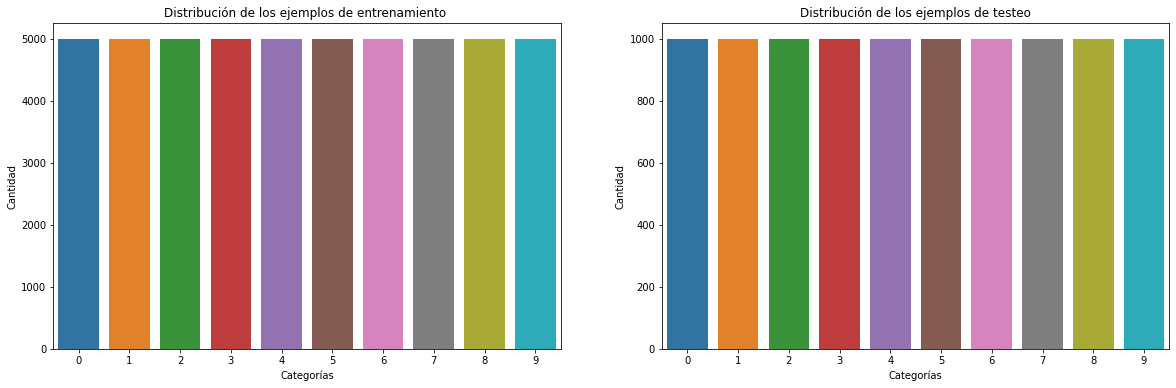

In [4]:
%matplotlib inline
import seaborn as sns
fig, axes = plt.subplots(1,2,figsize=(20,6)) 
# Plot del set de entrenamiento
sns.countplot(Y_train.reshape(-1), ax=axes[0])
axes[0].set_title('Distribución de los ejemplos de entrenamiento ')
axes[0].set_xlabel('Categorías')
axes[0].set_ylabel('Cantidad')
# Plot del set de testeo
sns.countplot(Y_test.reshape(-1), ax=axes[1])
axes[1].set_title('Distribución de los ejemplos de testeo')
axes[1].set_xlabel('Categorías')
axes[1].set_ylabel('Cantidad')


A continuación vamos a pre-procesar las imágenes. Para ello vamos a convertir todos los datos a float y además normalizamos. De igual manera, debemos pre-procesar las categorías y para ello vamos a aplicar One Hot Encoder, que es básicamente convertir el vector de clases en una matriz binaria. Nuestro vector de clases toma valores entre 0 y 9, así que vamos a elegir por ejemplo la categoría 1 y convertirla a binaria: \\
1 --OneHotEncoder--> [0,1,0,0,0,0,0,0,0,0] \\
De igual manera para la categoría 5: \\
5 --OneHotEncoder--> [0,0,0,0,0,1,0,0,0,0]

In [5]:
X_train = (X_train.astype('float32'))/255. #El rango del píxel es desde 0 a 255
X_test = (X_test.astype('float32'))/255. #Igual para el set de testeo

Y_train = keras.utils.to_categorical(Y_train,num_classes = num_clases)
Y_test = keras.utils.to_categorical(Y_test,num_classes=num_clases) 

<h2> Modelo a Utilizar </h2>

Tal y como adelantamos antes, el modelo que vamos a utilizar es una red neuronal convolucional (CNN). Vamos a dividir la CNN en tres partes: \\
<b> Primera Parte. </b> Aplicamos en primer lugar dos Conv2D de 32 filtros de tamaño 3x3 con una ReLU de activación. El padding será "same". A continuación aplicamos una capa de MaxPooling2D (2x2). \\
<b> Segunda Parte. </b> Ahora añadimos otras dos capas Conv2D, una de 32 y otra de 64, dimensiones 3x3, ReLU y pad="same". Finalizamos con MaxPooling2D(2x2) y un Dropout del 30%. \\
<b> Tercera Parte. </b> Vamos a "aplanar" la imagen (Flatten) y este vector será la entrada de una red neuronal artificial "densamente" conectada, también conocida como Fully Connected. En esta ocasión tendremos también una ReLU y un Dropout del 25%.

In [6]:
ConvNet = Sequential([
                      Conv2D(32,(3,3), padding='same',input_shape=X_train.shape[1:]),
                      Conv2D(64,(3,3), activation='relu', padding='same'),
                      MaxPooling2D(pool_size=(2,2)),
                      Dropout(0.5),
                      Conv2D(64,(3,3), activation='relu', padding='same'),
                      Conv2D(128,(3,3), activation='relu', padding='same'),
                      MaxPooling2D(pool_size=(2,2)),
                      Dropout(0.5),
                      Flatten(),
                      Dense(512,activation='relu'),
                      Dropout(0.25),
                      Dense(num_clases,activation='softmax')
])

In [7]:
ConvNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0

In [8]:
#Vamos a entrenar el modelo utilizando optimización por SGD.
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.1)

ConvNet.compile(optimizer=optimizer, loss='CategoricalCrossentropy', metrics=['accuracy'])

In [10]:
train_CNN = ConvNet.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs,shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8652 - accuracy: 0.6960
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.8251 - accuracy: 0.7079
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7843 - accuracy: 0.7231
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7529 - accuracy: 0.7349
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.7266 - accuracy: 0.7433
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.6959 - accuracy: 0.7557
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.6625 - accuracy: 0.7663
Epoch 8/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.6373 - accuracy: 0.7739
Epoch 9/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.6151 - accuracy: 0.7827
Epoch 10/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.585

In [11]:
#Predicciones utilizando el modelo
Y_hat = ConvNet.predict(X_test)

In [12]:
Y_hat_nice = np.argmax(Y_hat, axis=-1)
Y_test_nice = np.argmax(Y_test, axis=-1)

In [13]:
import os
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# Guardamos el modelo
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
ConvNet.save(model_path)
print('Modelo guardado en %s ' % model_path)

# Score trained model.
scores = ConvNet.evaluate(X_test, Y_test)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Modelo guardado en /content/saved_models/keras_cifar10_trained_model.h5 
313/313 [==============================] - 1s 3ms/step - loss: 0.6471 - accuracy: 0.7731
Test loss: 0.6471144556999207
Test accuracy: 0.7731000185012817


In [14]:
from sklearn.metrics import classification_report

In [15]:
print(classification_report( Y_test_nice, Y_hat_nice))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1000
           1       0.88      0.89      0.89      1000
           2       0.71      0.67      0.69      1000
           3       0.66      0.52      0.58      1000
           4       0.73      0.74      0.73      1000
           5       0.73      0.63      0.68      1000
           6       0.70      0.92      0.79      1000
           7       0.81      0.84      0.83      1000
           8       0.81      0.92      0.86      1000
           9       0.88      0.82      0.85      1000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



In [16]:
labels = ['Avión', 'Coche', 'Pájaro', 'Gato', 'Reno', 'Perro', 'Rana', 'Caballo', 'Barco', 'Camión']

Ahora comprobemos algunas de las predicciones que se han hecho bien:

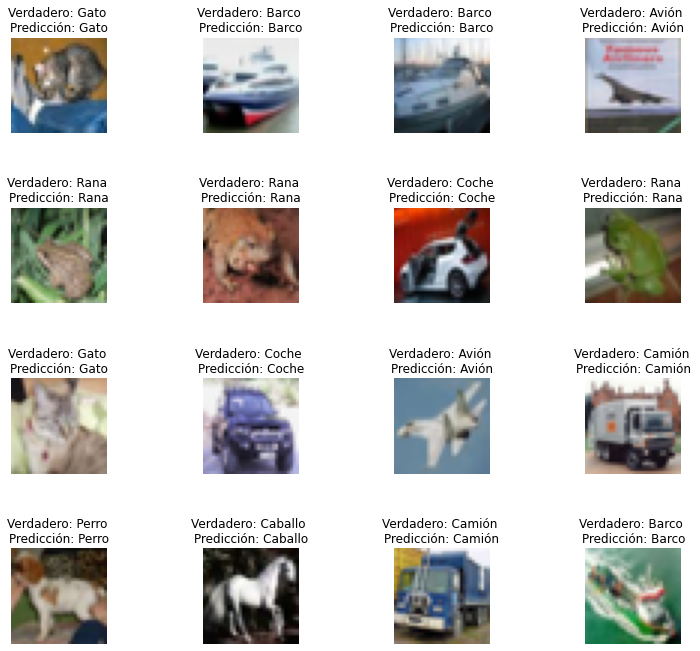

In [21]:
R = 4
C = 4
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

misclassified_idx = np.where((Y_hat_nice == Y_test_nice))[0]
for i in np.arange(0, R*C):
    axes[i].imshow(X_test[misclassified_idx[i]])
    axes[i].set_title("Verdadero: %s \nPredicción: %s" % (labels[Y_test_nice[misclassified_idx[i]]], 
                                                  labels[Y_hat_nice[misclassified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

Y ahora algunas predicciones mal hechas:

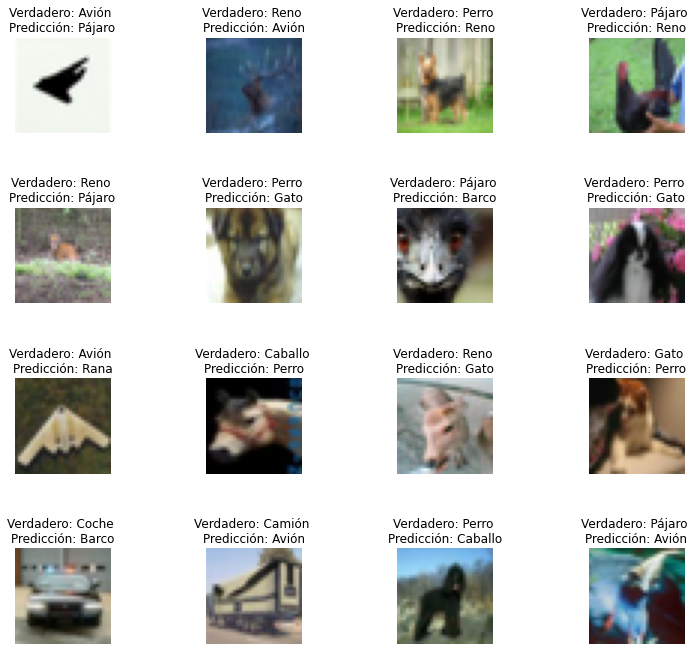

In [24]:
R2 = 4
C2 = 4
fig2, axes2 = plt.subplots(R, C, figsize=(12,12))
axes2 = axes2.ravel()

misclassified_idx2 = np.where((Y_hat_nice != Y_test_nice))[0]
for i in np.arange(0, R2*C2):
    axes2[i].imshow(X_test[misclassified_idx2[i]])
    axes2[i].set_title("Verdadero: %s \nPredicción: %s" % (labels[Y_test_nice[misclassified_idx2[i]]], 
                                                  labels[Y_hat_nice[misclassified_idx2[i]]]))
    axes2[i].axis('off')
    plt.subplots_adjust(wspace=1)